<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Trading Strategies (b)

In [207]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings

In [208]:
warnings.simplefilter('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%matplotlib inline

## Linear OLS Regression

### The Data

In [209]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [210]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [211]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2138 non-null   float64
 9   XAU=    2138 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 217.1 KB


In [212]:
raw.head(5)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37


In [213]:
symbol = 'EUR='

In [214]:
data = pd.DataFrame(raw[symbol])

In [215]:
data['returns'] = np.log(data / data.shift(1))

In [216]:
data.dropna(inplace=True)

In [217]:
# np.sign来判断负数还是正数
data['direction'] = np.sign(data['returns']).astype(int)

In [218]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


In [219]:
data['direction'].value_counts()

 1    1076
-1    1052
 0       9
Name: direction, dtype: int64

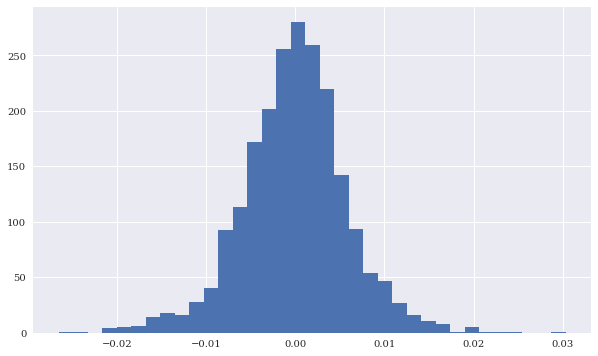

In [220]:
data['returns'].hist(bins=35, figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_01.png')

In [221]:
import scipy.stats as scs
def normality_tests(arr):
    ''' Tests for normality distribution of given data set.
    
    Parameters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    # 测试样本数据的偏斜是否“正态”（也就是值足够接近0）
    print('Skew of data set  %14.3f' % scs.skew(arr))
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])
    # 与偏斜度测试类似，测试样本数据的峰度是否“正态”（同样是值足够接近0）。
    print('Kurt of data set  %14.3f' % scs.kurtosis(arr))
    print('Kurt test p-value %14.3f' % scs.kurtosistest(arr)[1])
    # 组合其他两种测试方法，检验正态性。
    print('Norm test p-value %14.3f' % scs.normaltest(arr)[1])

In [222]:
# skew的p值很高，说明回报率的分布跟正态分布高概率一致
# kurt和normaltest说明不是正态分布
normality_tests(data['returns'])

Skew of data set          -0.052
Skew test p-value          0.321
Kurt of data set           1.515
Kurt test p-value          0.000
Norm test p-value          0.000


In [223]:
# 落后两期
lags = 2

In [224]:
def create_lags(data):
    # 在本函数之外也想引用cols，所以用global声明全局变数
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)
        data.dropna(inplace = True)

In [225]:
create_lags(data)

In [226]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984
2010-01-14,1.4502,-0.000551,-1,0.001103,-0.001310


In [227]:
data.dropna(inplace=True)

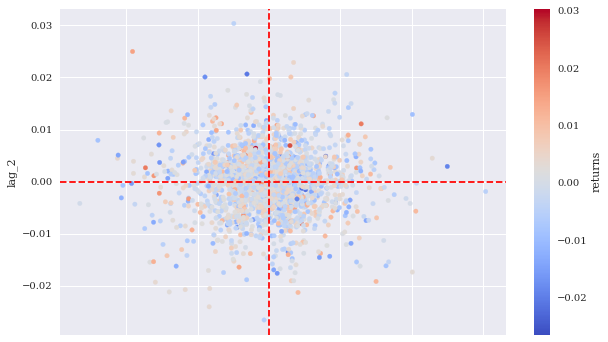

In [228]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns',  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');
# plt.savefig('../../images/ch15/strat_ml_02.png');

### Regression

用回归做策略。

Using the log returns or only the direction data


In [229]:
# 线性回归
from sklearn.linear_model import LinearRegression  

In [230]:
model = LinearRegression()  
LinearRegression?

Init signature:
LinearRegression(
    *,
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    n_jobs=None,
)
Docstring:     
Ordinary least squares Linear Regression.

LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
to minimize the residual sum of squares between the observed targets in
the dataset, and the targets predicted by the linear approximation.

Parameters
----------
fit_intercept : bool, default=True
    Whether to calculate the intercept for this model. If set
    to False, no intercept will be used in calculations
    (i.e. data is expected to be centered).

normalize : bool, default=False
    This parameter is ignored when ``fit_intercept`` is set to False.
    If True, the regressors X will be normalized before regression by
    subtracting the mean and dividing by the l2-norm.
    If you wish to standardize, please use
    :class:`sklearn.preprocessing.StandardScaler` before calling ``fit`` on
    an estimator with ``normalize=False`

In [231]:
# 预测returns
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])  

In [232]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])  

In [233]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-08,0.000018,0.040485
2010-01-11,-0.000238,-0.010766
2010-01-12,-0.000136,-0.042886
2010-01-13,-0.000021,0.002387
2010-01-14,-0.000122,0.007723


In [234]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,0.000018,0.040485
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-0.000238,-0.010766
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-0.000136,-0.042886
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,-0.000021,0.002387
2010-01-14,1.4502,-0.000551,-1,0.001103,-0.001310,-0.000122,0.007723


In [235]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)  

In [236]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,-1,1
2010-01-14,1.4502,-0.000551,-1,0.001103,-0.001310,-1,1


In [237]:
data['pos_ols_1'].value_counts()  

-1    1841
 1     293
Name: pos_ols_1, dtype: int64

In [238]:
data['pos_ols_2'].value_counts()  

 1    1389
-1     745
Name: pos_ols_2, dtype: int64

In [239]:
pd.crosstab?

Signature:
pd.crosstab(
    index,
    columns,
    values=None,
    rownames=None,
    colnames=None,
    aggfunc=None,
    margins=False,
    margins_name: str = 'All',
    dropna: bool = True,
    normalize=False,
) -> 'DataFrame'
Docstring:
Compute a simple cross tabulation of two (or more) factors. By default
computes a frequency table of the factors unless an array of values and an
aggregation function are passed.

Parameters
----------
index : array-like, Series, or list of arrays/Series
    Values to group by in the rows.
columns : array-like, Series, or list of arrays/Series
    Values to group by in the columns.
values : array-like, optional
    Array of values to aggregate according to the factors.
    Requires `aggfunc` be specified.
rownames : sequence, default None
    If passed, must match number of row arrays passed.
colnames : sequence, default None
    If passed, must match number of column arrays passed.
aggfunc : function, optional
    If specified, requires `values

In [240]:
# 算出两个策略的各种情况的次数
pd.crosstab(data['pos_ols_1'], data['pos_ols_2'], rownames = ['pos_ols_1'], colnames = ['pos_ols_2'])

pos_ols_2,-1,1
pos_ols_1,,
-1,718,1123
1,27,266


In [241]:
data.diff?

Signature: data.diff(periods: int = 1, axis: Union[str, int] = 0) -> 'DataFrame'
Docstring:
First discrete difference of element.

Calculates the difference of a Dataframe element compared with another
element in the Dataframe (default is element in previous row).

Parameters
----------
periods : int, default 1
    Periods to shift for calculating difference, accepts negative
    values.
axis : {0 or 'index', 1 or 'columns'}, default 0
    Take difference over rows (0) or columns (1).

Returns
-------
Dataframe
    First differences of the Series.

See Also
--------
Dataframe.pct_change: Percent change over given number of periods.
Dataframe.shift: Shift index by desired number of periods with an
    optional time freq.
Series.diff: First discrete difference of object.

Notes
-----
For boolean dtypes, this uses :meth:`operator.xor` rather than
:meth:`operator.sub`.
The result is calculated according to current dtype in Dataframe,
however dtype of the result is always float64.

Examples

In [242]:
# 看一个数列里面的数字差。差为0就是没有变动仓位
# 第一个策略调整了562次
(data['pos_ols_1'].diff() != 0).sum()  

562

In [243]:
(data['pos_ols_2'].diff() != 0).sum()  

759

In [244]:
# 起始这个return的求法是不对的。因为相应的returns是前一天收盘价到今天收盘价的回报率。如果符合这个回报率，说明前一天必须在收盘前下单。但是lag_1的数据在前一天收盘前是得不到的，所以利用了未来的信息
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [245]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [246]:
data['strat_ols_mixed'] = (data['strat_ols_1'] + data['strat_ols_2']) / 2

In [247]:
data[['returns', 'strat_ols_1', 'strat_ols_2', 'strat_ols_mixed']].sum().apply(np.exp)

returns            0.815966
strat_ols_1        0.960286
strat_ols_2        1.375713
strat_ols_mixed    1.149382
dtype: float64

In [248]:
data[['returns', 'strat_ols_1', 'strat_ols_2', 'strat_ols_mixed']].std() * np.sqrt(252)
# 因为两个策略一个做多，一个做空，所以两个波动率差不多
# 混合策略的情况下，因为多空对冲，所以波动率下降

returns            0.094179
strat_ols_1        0.094191
strat_ols_2        0.094162
strat_ols_mixed    0.067811
dtype: float64

In [249]:
(data['direction'] == data['pos_ols_1']).value_counts()  

False    1092
True     1042
dtype: int64

In [250]:
1042 / (1092 + 1042)

0.48828491096532334

In [251]:
(data['direction'] == data['pos_ols_1']).mean()
# 因为就是1和0(True和False)，所以平均值就是正确率

0.48828491096532334

In [252]:
(data['direction'] == data['pos_ols_2']).value_counts()  

True     1099
False    1035
dtype: int64

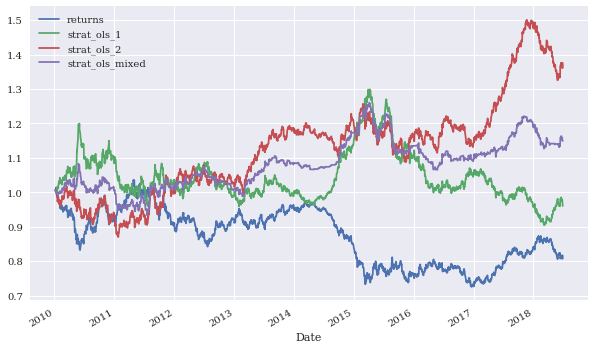

In [253]:
data[['returns', 'strat_ols_1', 'strat_ols_2', 'strat_ols_mixed']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_03.png');

## Clustering

分群

In [272]:
from sklearn.cluster import KMeans

In [256]:
KMeans?

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001,
    precompute_distances='deprecated',
    verbose=0,
    random_state=None,
    copy_x=True,
    n_jobs='deprecated',
    algorithm='auto',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random', ndarray, callable}, default='k-means++'
    Method for initialization:

    'k-means++' : selects initial cluster centers for k-mean
    clustering in a smart way to speed up convergence. See section
    Notes in k_init for more details.

    'random': choose `n_clusters` observations (rows) at random from data
    for the initial centroids.

    If an ndarray is passed, it should be of shape (n_clusters, n_features)
    and gives the initial centers.

    If a callable is passe

In [273]:
# 分2群
# random_state：因为最开始会做10次随机中心值
model = KMeans(n_clusters=2, random_state=0)  #  <1>

In [258]:
data

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,strat_ols_mixed
Date,,,,,,,,,,
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544,0.006544
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984,-0.006984
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310,0.001310
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,-1,1,-0.001103,0.001103,0.000000
2010-01-14,1.4502,-0.000551,-1,0.001103,-0.001310,-1,1,0.000551,-0.000551,0.000000
...,...,...,...,...,...,...,...,...,...,...
2018-06-25,1.1702,0.004024,1,0.004644,0.002676,-1,-1,-0.004024,-0.004024,-0.004024
2018-06-26,1.1645,-0.004883,-1,0.004024,0.004644,-1,-1,0.004883,0.004883,0.004883
2018-06-27,1.1552,-0.008018,-1,-0.004883,0.004024,1,1,-0.008018,-0.008018,-0.008018


In [274]:
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [275]:
data['pos_clus'] = model.predict(data[cols])

In [276]:
data

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,strat_ols_mixed,pos_clus
Date,,,,,,,,,,,
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544,0.006544,0
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984,-0.006984,1
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310,0.001310,1
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,-1,1,-0.001103,0.001103,0.000000,0
2010-01-14,1.4502,-0.000551,-1,0.001103,-0.001310,-1,1,0.000551,-0.000551,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,1.1702,0.004024,1,0.004644,0.002676,-1,-1,-0.004024,-0.004024,-0.004024,1
2018-06-26,1.1645,-0.004883,-1,0.004024,0.004644,-1,-1,0.004883,0.004883,0.004883,0
2018-06-27,1.1552,-0.008018,-1,-0.004883,0.004024,1,1,-0.008018,-0.008018,-0.008018,0


In [277]:
data['pos_clus'].values

array([0, 1, 1, ..., 0, 0, 1])

In [278]:
data['pos_clus'].value_counts()

1    1138
0     996
Name: pos_clus, dtype: int64

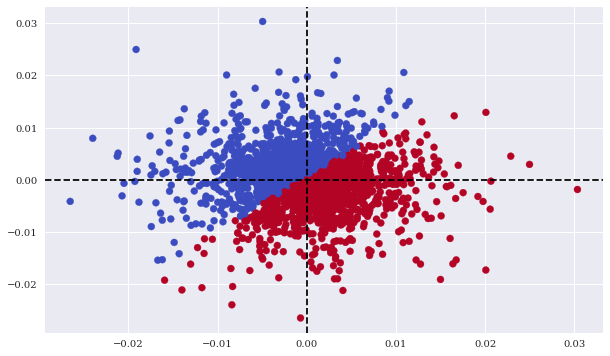

In [279]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm');
plt.axvline(0, c = 'k', ls='--')
plt.axhline(0, c = 'k', ls='--')
# plt.savefig('../../images/ch15/strat_ml_04.png');

In [280]:
pd.crosstab(data['direction'], data['pos_clus'], 
            rownames=['direction'], colnames=['pos_clus'])

pos_clus,0,1
direction,,
-1,489,561
0,4,5
1,503,572


In [281]:
# 这个是一种猜测。虽然分了两群，但是不知道哪一个做多哪一个做空
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)  

In [282]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [283]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.815966
strat_clus    1.108197
dtype: float64

In [284]:
(data['direction'] == data['pos_clus']).value_counts()

False    1070
True     1064
dtype: int64

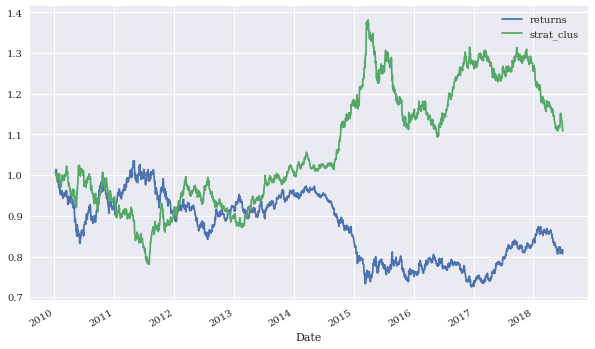

In [285]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_05.png');

## Frequency Approach

lag_1和lag_2分类，然后看看每一个分类情况下的direction的结果。

In [287]:
np.digitize?

Signature: np.digitize(x, bins, right=False)
Docstring:
Return the indices of the bins to which each value in input array belongs.

=========  =============  ============================
`right`    order of bins  returned index `i` satisfies
=========  =============  ============================
``False``  increasing     ``bins[i-1] <= x < bins[i]``
``True``   increasing     ``bins[i-1] < x <= bins[i]``
``False``  decreasing     ``bins[i-1] > x >= bins[i]``
``True``   decreasing     ``bins[i-1] >= x > bins[i]``
=========  =============  ============================

If values in `x` are beyond the bounds of `bins`, 0 or ``len(bins)`` is
returned as appropriate.

Parameters
----------
x : array_like
    Input array to be binned. Prior to NumPy 1.10.0, this array had to
    be 1-dimensional, but can now have any shape.
bins : array_like
    Array of bins. It has to be 1-dimensional and monotonic.
right : bool, optional
    Indicating whether the intervals include the right or the left bi

In [286]:
# 分界。小于0就是0，大于等于0就是1
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [288]:
create_bins(data)

In [291]:
data[['direction'] + cols_bin].head() 
#  direction为1的话，之后一期的lag_1_bin和两期的lag_2_bin就是1，反之就是0。因为计算方法

,direction,lag_1_bin,lag_2_bin
Date,,,
2010-01-08,1,0,1
2010-01-11,1,1,0
2010-01-12,-1,1,1
2010-01-13,1,0,1
2010-01-14,-1,1,0


In [292]:
data.groupby?

Signature:
data.groupby(
    by=None,
    axis=0,
    level=None,
    as_index: bool = True,
    sort: bool = True,
    group_keys: bool = True,
    squeeze: bool = <object object at 0x0000016FF2F75910>,
    observed: bool = False,
    dropna: bool = True,
) -> 'DataFrameGroupBy'
Docstring:
Group DataFrame using a mapper or by a Series of columns.

A groupby operation involves some combination of splitting the
object, applying a function, and combining the results. This can be
used to group large amounts of data and compute operations on these
groups.

Parameters
----------
by : mapping, function, label, or list of labels
    Used to determine the groups for the groupby.
    If ``by`` is a function, it's called on each value of the object's
    index. If a dict or Series is passed, the Series or dict VALUES
    will be used to determine the groups (the Series' values are first
    aligned; see ``.align()`` method). If an ndarray is passed, the
    values are used as-is determine the gr

In [290]:
# 这三列的所有可能性。grouped是dataframe的群
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()  

lag_1_bin  lag_2_bin  direction
0          0          -1           239
                       0             4
                       1           258
           1          -1           262
                       1           288
1          0          -1           271
                       0             1
                       1           278
           1          -1           278
                       0             4
                       1           251
dtype: int64

In [294]:
# unstack：把direction变成列头。fill_value=0就是如果没有对应的情况就填入0
res = grouped['direction'].size().unstack(fill_value=0)  

In [295]:
# 高亮每一群里面的最大值
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]  

In [296]:
res.style.apply(highlight_max, axis=1)  

In [297]:
# 根据上面的结果，如果之前两期是涨的，下一天跌的可能性大
# 所以这种情况下看空
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)  

In [298]:
(data['direction'] == data['pos_freq']).value_counts()

True     1102
False    1032
dtype: int64

In [299]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [300]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.815966
strat_freq    0.996009
dtype: float64

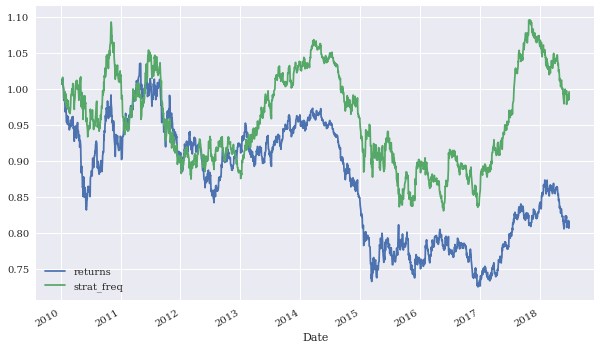

In [301]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_06.png');

## Classification Algorithms

In [68]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [69]:
C = 1

In [70]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [71]:
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()} 

In [72]:
fit_models(data)

In [73]:
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [74]:
derive_positions(data)

In [75]:
def evaluate_strats(data):  
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model 
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [76]:
evaluate_strats(data)

In [77]:
sel.insert(1, 'strat_freq')

In [78]:
data[sel].sum().apply(np.exp)  

returns           0.815966
strat_freq        0.996009
strat_log_reg     1.235213
strat_gauss_nb    1.235213
strat_svm         0.996009
dtype: float64

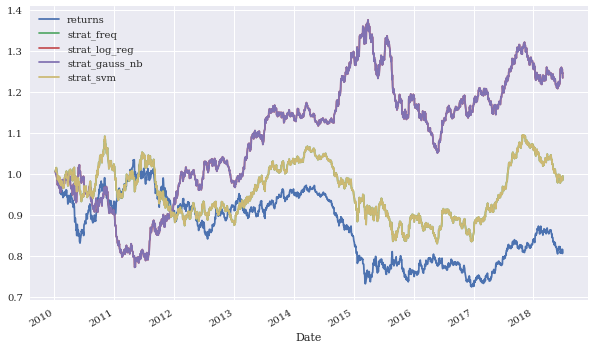

In [79]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_07.png')

In [80]:
data = pd.DataFrame(raw[symbol])

In [81]:
data['returns'] = np.log(data / data.shift(1))

In [82]:
data['direction'] = np.sign(data['returns'])

In [83]:
lags = 5  
create_lags(data)
data.dropna(inplace=True)

In [84]:
create_bins(data)  
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [85]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-27,0,1,1,0,0
2010-01-28,0,0,1,1,0
2010-01-29,0,0,0,1,1
2010-02-01,0,0,0,0,1
2010-02-02,1,0,0,0,0


In [86]:
data.dropna(inplace=True)

In [87]:
fit_models(data)

In [88]:
derive_positions(data)

In [89]:
evaluate_strats(data)

In [90]:
data[sel].sum().apply(np.exp)

returns           0.830171
strat_log_reg     1.135990
strat_gauss_nb    1.135990
strat_svm         2.700374
dtype: float64

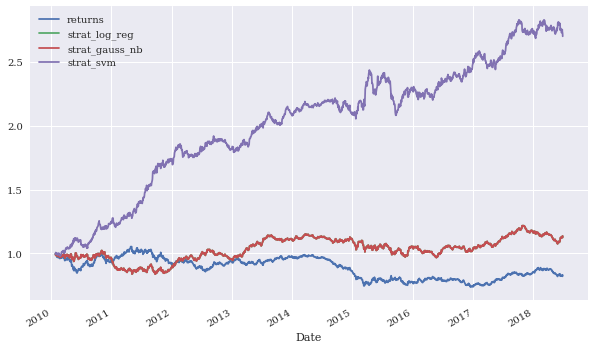

In [91]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_08.png');

In [92]:
mu = data['returns'].mean()  
v = data['returns'].std()  

In [93]:
bins = [mu - v, mu, mu + v]  
bins  

[-0.006020152249348994, -8.771125083855606e-05, 0.005844729747671881]

In [94]:
create_bins(data, bins)

In [95]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-27,1,2,2,1,0
2010-01-28,1,1,2,2,1
2010-01-29,1,1,1,2,2
2010-02-01,0,1,1,1,2
2010-02-02,2,0,1,1,1


In [96]:
fit_models(data)

In [97]:
derive_positions(data)

In [98]:
evaluate_strats(data)

In [99]:
data[sel].sum().apply(np.exp)

returns           0.830171
strat_log_reg     1.425236
strat_gauss_nb    1.759735
strat_svm         5.859604
dtype: float64

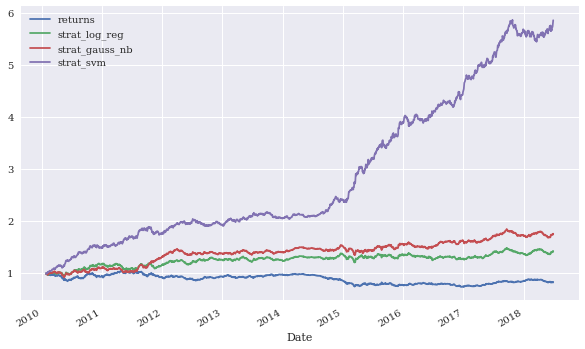

In [100]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_09.png')

### Sequential Train-Test Split

In [101]:
split = int(len(data) * 0.5)

In [102]:
train = data.iloc[:split].copy()  

In [103]:
fit_models(train)  

In [104]:
test = data.iloc[split:].copy()  

In [105]:
derive_positions(test)  

In [106]:
evaluate_strats(test)  

In [107]:
test[sel].sum().apply(np.exp)

returns           0.845491
strat_log_reg     0.930688
strat_gauss_nb    0.893653
strat_svm         0.992277
dtype: float64

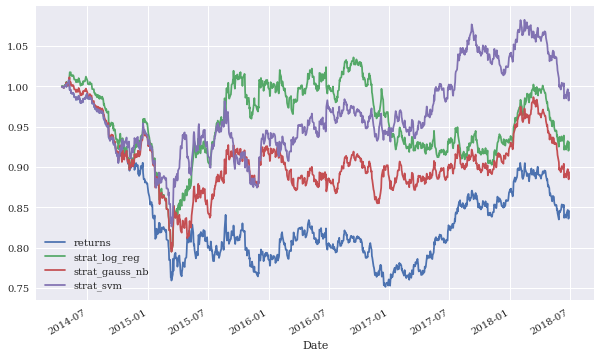

In [108]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_10.png');

### Randomized Train-Test Split

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
train, test = train_test_split(data, test_size=0.5,
                               shuffle=True, random_state=100)

In [111]:
train = train.copy().sort_index()  

In [112]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-27,1,2,2,1,0
2010-01-28,1,1,2,2,1
2010-01-29,1,1,1,2,2
2010-02-01,0,1,1,1,2
2010-02-03,2,2,0,1,1


In [113]:
test = test.copy().sort_index()  

In [114]:
fit_models(train)

In [115]:
derive_positions(test)

In [116]:
evaluate_strats(test)

In [117]:
test[sel].sum().apply(np.exp)

returns           0.794102
strat_log_reg     1.003849
strat_gauss_nb    0.795696
strat_svm         0.857465
dtype: float64

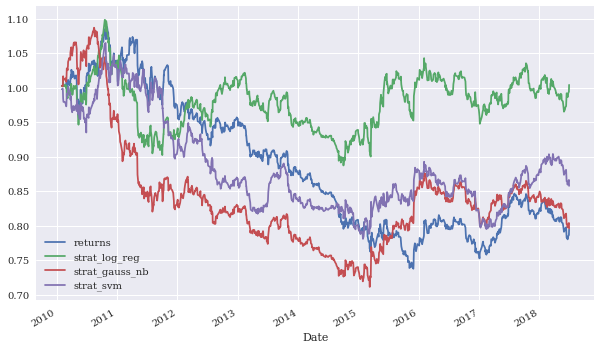

In [118]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_11.png');

## Deep Neural Network

### DNN with scikit-learn

In [119]:
from sklearn.neural_network import MLPClassifier

In [120]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1)

In [121]:
%time model.fit(data[cols_bin], data['direction'])

Wall time: 13.1 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [122]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [123]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [124]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.830171
strat_dnn_sk    40.592212
dtype: float64

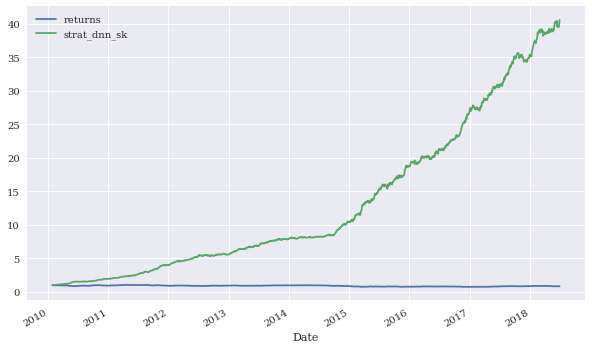

In [125]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_12.png');

In [126]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [127]:
train = train.copy().sort_index()

In [128]:
test = test.copy().sort_index()

In [129]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [500], random_state=1)  

In [130]:
%time model.fit(train[cols_bin], train['direction'])

Wall time: 1min 36s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [131]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [132]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [133]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.794102
strat_dnn_sk    1.075349
dtype: float64

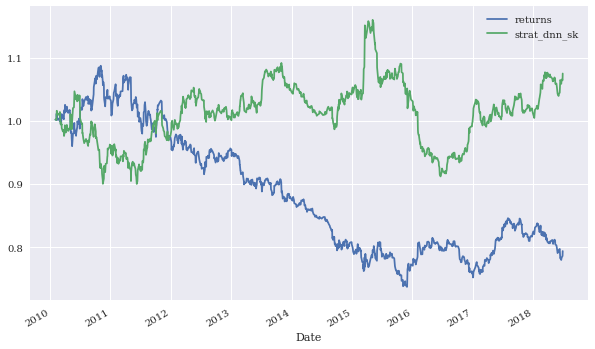

In [134]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_13.png');

### DNN with Keras & TensorFlow Backend

In [135]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

ModuleNotFoundError: No module named 'keras'

In [136]:
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=lags))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [137]:
data_ = (data - data.mean()) / data.std()
data['direction_'] = np.where(data['direction'] == 1, 1, 0)

In [138]:
model = create_model()

AttributeError: module 'tensorflow._api.v1.random' has no attribute 'set_seed'

In [139]:
%%time
model.fit(data_[cols], data['direction_'],
          epochs=50, verbose=False)

TypeError: fit() got an unexpected keyword argument 'epochs'

In [140]:
model.evaluate(data_[cols], data['direction_'])

AttributeError: 'MLPClassifier' object has no attribute 'evaluate'

In [141]:
pred = np.where(model.predict(data_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [142]:
data['pos_dnn_ke'] = np.where(pred > 0, 1, -1)  

In [143]:
data['strat_dnn_ke'] = data['pos_dnn_ke'] * data['returns']

In [144]:
data[['returns', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.830171
strat_dnn_ke    1.030055
dtype: float64

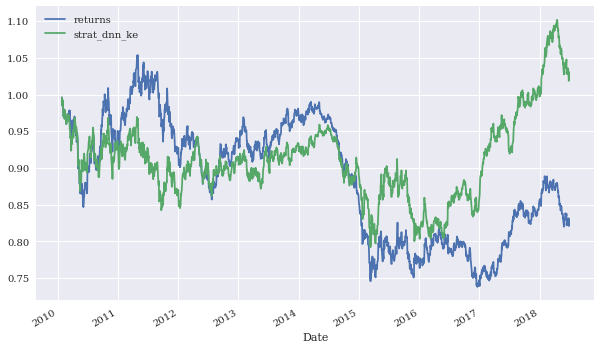

In [145]:
data[['returns', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_14.png');

In [146]:
mu, std = train.mean(), train.std()

In [147]:
train_ = (train - mu) / mu.std()

In [148]:
model = create_model()

AttributeError: module 'tensorflow._api.v1.random' has no attribute 'set_seed'

In [149]:
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [150]:
%%time
model.fit(train_[cols], train['direction_'],
          epochs=50, verbose=False)

TypeError: fit() got an unexpected keyword argument 'epochs'

In [151]:
test_ = (test - mu) / std

In [152]:
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [153]:
model.evaluate(test_[cols], test['direction_'])

AttributeError: 'MLPClassifier' object has no attribute 'evaluate'

In [154]:
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [155]:
test['pos_dnn_ke'] = np.where(pred > 0, 1, -1)

In [156]:
test['strat_dnn_ke'] = test['pos_dnn_ke'] * test['returns']

In [157]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.794102
strat_dnn_sk    1.075349
strat_dnn_ke    0.688727
dtype: float64

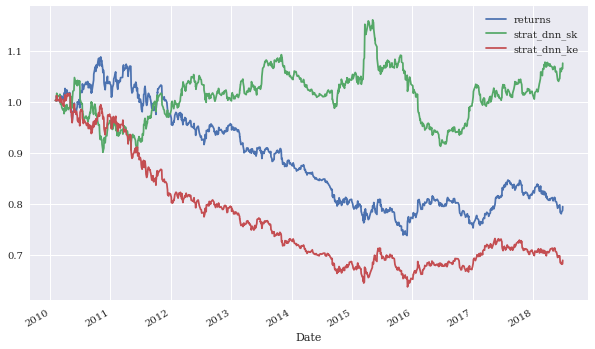

In [158]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_15.png');